<a href="https://colab.research.google.com/github/alexandergribenchenko/Acamica_Proyecto_02/blob/main/DS_Proyecto_02_V_20.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Proyecto 02 - Ingeniería de features, Modelos avanzados e Interpretación de modelos** (Armado) V_19

### (Acámica - DS online 40 - Proyecto 02 - Alexander Ortega)

# **Alcance y objeto del proyecto:**


El presente proyecto tiene como finalidad exhibir e implementar un conjunto de herramientas analíticas y predictivas propias de problemas del aprendizaje supervisado, más especificamante de problemas de regresión, empleando como contexto específico el estudio de los precios de los inmuebles de la Ciudad de Buenos Aires entre 2019 y enero de 2020, con el fin de generar y evaluar modelos que permitan hacer su predicción. 

##### ---> Librerías a emplear en el proyecto:

In [1]:
!pip install --upgrade scikit-learn

     |████████████████████████████████| 22.3MB 59.9MB/s 
  Found existing installation: scikit-learn 0.22.2.post1
    Uninstalling scikit-learn-0.22.2.post1:
      Successfully uninstalled scikit-learn-0.22.2.post1


In [2]:
!pip install --upgrade xgboost

     |████████████████████████████████| 166.7MB 82kB/s 
  Found existing installation: xgboost 0.90
    Uninstalling xgboost-0.90:
      Successfully uninstalled xgboost-0.90


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV

from sklearn.ensemble import RandomForestRegressor
import xgboost as xgb
from xgboost import plot_importance, plot_tree

import pickle
import sys

pd.set_option('display.max_columns', None)

import time
start_time = time.time()

import warnings
warnings.filterwarnings("ignore")

# **Etapa Preliminar.** Preparación del dataset de análisis

En la presente etapa,  que dividiremos en  4 pasos, recopilaremos y cargaremos la información primaria para el estudio, exploramos el dataset cargado (raw) para entender mejor cada una de las variables y entender con ello qué tipo de procesamiento deberíamos aplicar, eliminaremos los atributos que hayamos encontrado que no sean relevantes para el modelo y filtraremos respecto a las categorías de interés, y finalmente definiremos el dataset base que será el que empleado de manera posterior en la etapa de Transformación de datos.

## **EP. 1.1.** Recopilación y descarga de la información primaria

La información base para el desarrollo del siguiente proyecto fue obtenida de la [página de la división de datos de Properati](https://www.properati.com.co/data/), una plataforma web enfocada en el mercado inmobiliario de 4 países de Latinoamérica: Argentina, Colombia, Perú y Ecuador. En específico en la sección de Datasets del enlace descrito encontramos el enlace de descarga directa  en formato CSV para cada uno de los países.

Para efectos del desarrollo del proyecto generamos únicamente la descarga del dataset de Argentina y tomamos en cuenta únicamente las propiedades publicadas entre 2019 y enero de 2020, ubicadas al interior del Gran Buenos Aires. 
 

## **EP. 1.2.** Exploración del dataset (raw)

Iniciaremos cargando y evaluando la información general del dataset descargado (Argentina, 2019):


In [4]:
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [5]:
path_data = '/content/drive/MyDrive/Colab Notebooks/00_Acamica/DS_Proyecto_01_Datos_Properati.csv'

In [6]:
df = pd.read_csv(path_data, sep =',')
df.head()

,start_date,end_date,created_on,lat,lon,l1,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,currency,title,description,property_type,operation_type
0,2019-10-17,2019-12-23,2019-10-17,-34.605880,-58.384949,Argentina,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,USD,"***Venta semipiso centro, ideal hostel*****",DESCRIPCION DE LA PROPIEDAD: Departamento de 1...,Departamento,Venta
1,2019-10-17,2019-11-21,2019-10-17,-34.624056,-58.412110,Argentina,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,USD,Espectacular PH reciclado en Boedo sin expensas.,PH reciclado en Boedo a una cuadra de la plaz...,PH,Venta
2,2019-10-17,2019-11-01,2019-10-17,-34.593569,-58.427474,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,USD,Depto.tipo casa de 2 ambientes en Venta en Pal...,"2 ambienets amplio , excelente estado , patio ...",PH,Venta
3,2019-10-17,2019-12-23,2019-10-17,-34.581294,-58.436754,Argentina,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,USD,COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...,HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...,PH,Venta
4,2019-10-17,2020-03-11,2019-10-17,-34.914194,-57.938219,Argentina,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,USD,58 entre 1 y 2 Venta de departamento en ph.1 ...,58 entre 1 y 2 Venta de departamento en PH. P...,PH,Venta


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 146660 entries, 0 to 146659
Data columns (total 19 columns):
 #   Column           Non-Null Count   Dtype  
---  ------           --------------   -----  
 0   start_date       146660 non-null  object 
 1   end_date         146660 non-null  object 
 2   created_on       146660 non-null  object 
 3   lat              136735 non-null  float64
 4   lon              136701 non-null  float64
 5   l1               146660 non-null  object 
 6   l2               146660 non-null  object 
 7   l3               146660 non-null  object 
 8   rooms            146660 non-null  float64
 9   bedrooms         146660 non-null  float64
 10  bathrooms        140703 non-null  float64
 11  surface_total    126133 non-null  float64
 12  surface_covered  125046 non-null  float64
 13  price            146660 non-null  float64
 14  currency         146660 non-null  object 
 15  title            146660 non-null  object 
 16  description      146660 non-null  obje

Corroboramos que el dataset cuenta con los siguientes 19 atributos:

- **start_date:** fecha en formato año-mes-día en que inició la publicación.

- **end_date:** fecha en formato año-mes-día en que finalizó la publicación.

- **created_on:** fecha en formato año-mes-día en que se creó la publicación.

- **lat:** latitud de la ubicación.

- **lon:** longitud de la ubiucación.

- **l1:** país del inmueble.

- **l2:** zona del Gran Buenos Aires donde esta ubicado.

- **l3:** barrio donde esta ubicado.

- **rooms:** cantidad de espacios independientes.

- **bedrooms:** cantidad de habitaciones.

- **bathrooms:** cantidad de baños.

- **surface_total:** superficie total.

- **surface_covered:** superficie construida.

- **price:** precio (este es nuestro target).

- **currency:** moneda en que esta dado el precio.

- **title:** titulo de la publicación.

- **description:** descripción del inmueble.

- **property_type:** tipo de propiedad.

- **operation_type:** tipo de operación.

Exploraremos ahora con mayor detalle cada uno de los atributos para determinar cuáles de ellos nos son útiles, de cuales de ellos debemos prescindir porque no representan información relevante en nuestro contexto y cuáles deben ser transformados de manera inicial para que tengan una representación más limpia y homogénea en el dataset. 

### **---> Exploración variable start_date, end_date, y created_on:**

In [8]:
df.start_date = pd.to_datetime(df.start_date)
print(df.start_date.min().date())
print(df.start_date.max().date())
df_temp = df.start_date.value_counts().to_frame().reset_index().sort_values(by=['index']).reset_index(drop=True)
df_temp=df_temp.groupby([pd.Grouper(key= 'index', freq='MS')])\
        .sum().reset_index()
df_temp['index'] = df_temp['index'].apply(lambda x: str(x.date())[0:7])
df_temp.columns=['Mes','Cantidad publicaciones']

2019-01-01
2020-01-25


(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12]),
 <a list of 13 Text major ticklabel objects>)

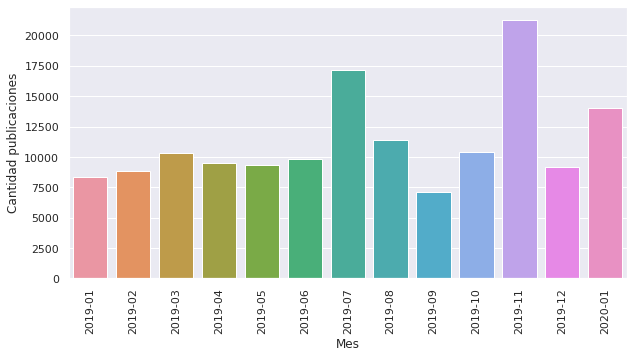

In [9]:
plt.figure(figsize = (10,5))
sns.barplot(data=df_temp, x="Mes", y="Cantidad publicaciones")
plt.xticks(rotation=90)

Aunque vemos que hay un comportamiento diferencial entre la cantidad de publicaciones en los diferentes meses del año, no centraremos nuestro estudio en dicho comportamiento. Si bien el precio de los inmuebles puede fluctuar dependiendo de la fecha de publicación, este comportamiento temporal es un comportamiento que se sugeriría estudiar con mayor detalle en el caso que se encuentre relevante para un segmento de inmuebles particular. 

Para nuestro caso específico prescindiremos de las variables asociadas a las fechas y asumiremos que las fechas tanto de inicio, finalización y creación de la publicación, no son relevantes frente a las restantes características de los inmuebles.

**Procesamiento a aplicar:** las variables que serán descartadas en el dataframe de analisis.


### **---> Exploración variables lat y lon:**

In [10]:
df[['lat','lon']].describe()

,lat,lon
count,136735.000000,136701.000000
mean,-34.604896,-58.465304
std,0.468428,0.486190
min,-35.318457,-180.000000
25%,-34.627667,-58.504012
50%,-34.600943,-58.443262
75%,-34.574600,-58.407586
max,85.051129,-57.805832


Aunque observamos que la distribución de latitudes y longitudes pueden presentar algunos valores atípicos en sus maximos y minimos, vemos acorde al percentil 75% y a su valor medio, que en general las latitudes y longitudes corresponden con las de la ciudad de buenos aires  (valores esperados próximos a: latitud 34.36 y longitud 58.26). 

Estas variables las tendremos en cuenta pues corresponden con geolocalizaciones, que en conjunto con otras variables de ubicación pueden presentar una influencia significativa en el precio de los inmuebles. 

**Procesamiento a aplicar:** las variables son de tipo numérico continuo. Se evaluarán y descartaran outliers y se escalarán sus datos. Los datos con valores faltantes no se imputarán, pues corresponden con a una ubicación muy específica para cada inmueble que no sería sensato obtener a partir de una imputación.



### **---> Exploración variables l1, l2 y l3:**

In [11]:
df.l1.value_counts(dropna=False)

Argentina    146660
Name: l1, dtype: int64

La variable l1 será descartada del total pues todos los inmuebles se encuentran en Argentina por lo cual no agrega valor alguno.

Capital Federal             63.10
Bs.As. G.B.A. Zona Norte    16.56
Bs.As. G.B.A. Zona Sur      11.71
Bs.As. G.B.A. Zona Oeste     8.64
Name: l2, dtype: float64


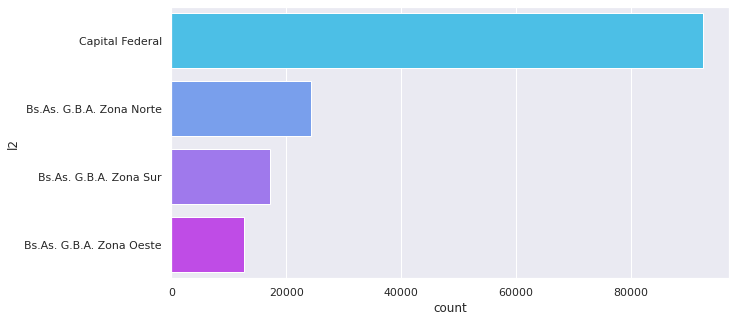

In [12]:
plt.figure(figsize = (10,5))
print(round(100*df.l2.value_counts(dropna=False, normalize=True),2))
sns.countplot(data = df, y = 'l2', order = df['l2'].value_counts().index, palette='cool')

Dado que acorde a la distribución de la variable l2 la zona más representativa en relación con la cantidad de registros es Capital Federal (63% de los registros), filtraremos nuestro dataset para tener únicamente en cuenta los de esta Zona y así tener resultados comparativos de los modelos con los presentados en el primer proyecto.

Palermo            8.91
Tigre              5.94
Almagro            5.13
Belgrano           4.73
Caballito          4.53
                   ... 
Cañuelas           0.07
Villa Soldati      0.05
Villa Riachuelo    0.03
Marcos Paz         0.02
Catalinas          0.00
Name: l3, Length: 89, dtype: float64


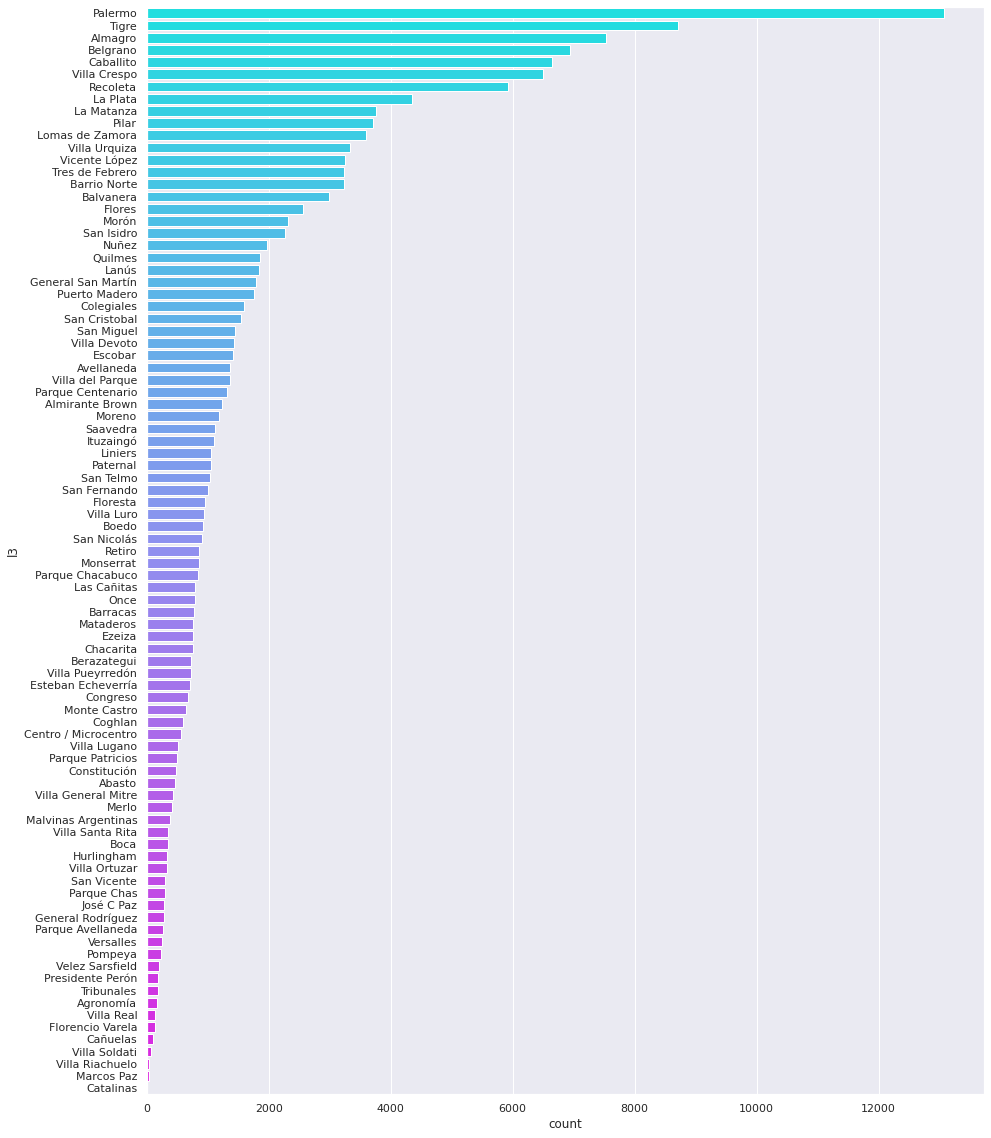

In [13]:
plt.figure(figsize = (15,20))
print(round(100*df.l3.value_counts(dropna=False, normalize=True),2))
sns.countplot(data = df, y = 'l3', order = df['l3'].value_counts().index, palette='cool')

Aunque respecto a la variable L3 se encuentra una distribución con barrios con cantidades significativas de registros (Palermo, Tigre, Almagro) y otros barrios con cantidades muy pequeñas (Catalinas, Marcos Paz), dejaremos todos los barrios para tener la totalidad de Capital federal para nuestro análisis. Además la localización del inmueble acorde al barrio puede ser una de las propiedades más sensibles para establecer su precio y queremos observar esta influencia en los modelos a evaluar.

**Procesamiento a aplicar:** las variables que son de tipo categórico nominal, por tanto para poder incluirlos en los modelos aplicaremos one hot encoding. Adicional a ello los valores faltantes podrán imputarse a partir de las variables restantes que se consideren de mayor interés (latitud y longitud de manera más específica para esta variable).

### **---> Exploración variables rooms, bedrooms, bathrooms:**

In [14]:
df[['rooms','bedrooms', 'bathrooms']].describe()

,rooms,bedrooms,bathrooms
count,146660.000000,146660.000000,140703.000000
mean,3.079817,1.983240,1.599994
std,1.416352,1.151304,0.889324
min,1.000000,0.000000,1.000000
25%,2.000000,1.000000,1.000000
50%,3.000000,2.000000,1.000000
75%,4.000000,3.000000,2.000000
max,35.000000,15.000000,14.000000


Acorde a la distribución de las variables encontramos fijándonos en el valor de los percentiles que por lo menos el 75% de las propiedades corresponden a inmuebles que tienen como máximo 4 espacios, 3 habitaciones y 2 baños. Esto corresponde en general con propiedades que seguramente serán del tipo Departamento, Casa o PH. 

Mantendremos todas las variables, pues en conjunto con la ubicación y la superficie pueden ser las variables más relevantes al determinar el precio de los inmuebles.

**Procesamiento a aplicar:** las variables que son de tipo numérico discreto y esto hace que se puedan tener 2 aproximaciones en su transformación. Por una parte al tratarse de variables numéricas podemos establecer outliers respecto a su distribución y podemos normalizarlas, y por otra parte, dado que los grupos en los cuales se distribuyen no son muchas pueden considerarse también como variables categóricas de tipo ordinal con lo cual podría aplicarse label encoding para incluirlas en el modelo. La elección de la bondad de un camino u otro se dará al momento de evaluar los modelos. Adicional a ello los valores faltantes podrán imputarse a partir de las variables restantes que se consideren de mayor interés (quizá superficie, tipo de propiedad y las restantes rooms, bedrooms y bathroms que se conozcan).


### **---> Exploración variables surface_total  y surface covered:**

In [15]:
df[['surface_total','surface_covered']].describe()

,surface_total,surface_covered
count,126133.000000,125046.000000
mean,216.872888,112.818011
std,2037.606649,916.857584
min,10.000000,1.000000
25%,52.000000,47.000000
50%,78.000000,68.000000
75%,140.000000,108.000000
max,193549.000000,126062.000000


Acorde a la distribución de las variables encontramos que son quizá las presentan un comportamiento menos homogéneo. Puede observarse como la desviación estándar es muy superior a los valores medios, y como entre los percentiles 75% y los valores máximos, o como entre el percentil 25% y los valores mínimos encontramos grandes brechas.

Dado que el tipo de propiedades que evaluaremos corresponden a propiedades de tipo del tipo Departamento, Casa o PH, en las cuales la mayoría la superficie construido abarca casi la totalidad de la perficie cubierta, eliminaremos la variable de superficie cubierta para que no presenten colinealidad, lo que puede hacer que algunos modelos (como el regresor lineal, por ejemplo) presenten comportamientos anómalos por no lograr discriminar de manera diferenciada el aporte que están teniendo cada una de las dos variables.

Sin embargo la variable que mantendremos, superficie total, será una de las variables más sensible al momento de estimar el precio de los inmuebles.

**Procesamiento a aplicar:** las variables son de tipo numérico continuo por lo cual se generará por un aparte eliminación de outliers y por otra escalado de los datos que acorde a la distribución puede ser de tipo logarítmico (dada la larga cola de la distribución, gran distancia entre el percentil 75 y los valores máximos). Adicional a ello los valores faltantes podrán imputarse a partir de las variables restantes que se consideren de mayor interés (cantidad de rooms, bedroooms y el otro valor de superficie si se conoce).

### **---> Exploración variable price:**

In [16]:
df[['price']].describe()

,price
count,1.466600e+05
mean,2.412211e+05
std,3.185195e+05
min,5.500000e+03
25%,1.110000e+05
50%,1.660000e+05
75%,2.650000e+05
max,3.243423e+07


La variable precio presenta un comportamiento similar a la variable superficie en cuanto a las distribuciones de percentiles, mínimos, máximos y desviaciones estándar. Por esta razón presentará un tratamiento similar. Es de resaltar además que esta es nuestra variable objetivo de estudio por lo cual debe mantenerse de manera obligatoria.

**Procesamiento a aplicar:** la variables son de tipo numérico continuo por lo cual se generará por un aparte eliminación de outliers y por otra escalado de los datos que acorde a la distribución puede ser de tipo logarítmico (dada la larga cola de la distribución, gran distancia entre el percentil 75 y los valores máximos). Adicional a ello los valores faltantes podrán imputarse a partir de las variables restantes que se consideren de mayor interés.

### **---> Exploración variable currency:**

In [17]:
df.currency.value_counts(dropna=False)

USD    146660
Name: currency, dtype: int64

La variable currency será descartada del total pues todos los inmuebles corresponden a dolares por lo cual no agrega valor alguno.

### **---> Exploración variables title y description:**

In [18]:
df.title

0               ***Venta semipiso centro, ideal hostel*****
1          Espectacular PH reciclado en Boedo sin expensas.
2         Depto.tipo casa de 2 ambientes en Venta en Pal...
3         COSTA RICA 5800 / PALERMO HOLLYWOOD / VENTA PH...
4         58 entre 1 y 2  Venta de departamento en ph.1 ...
                                ...                        
146655    Departamento en Venta en Barrio Privado Barran...
146656    Venta departamentos tres dormitorios jardín co...
146657    Venta departamento de un ambiente Manzanares C...
146658             Departamento en Venta. Manzanares chico.
146659            Departamento en venta en Manzanares Chico
Name: title, Length: 146660, dtype: object

In [19]:
df.description

0         DESCRIPCION DE LA PROPIEDAD: Departamento de 1...
1          PH reciclado en Boedo a una cuadra de la plaz...
2         2 ambienets amplio , excelente estado , patio ...
3         HERMOSO PH EN PALERMO!!!2 AMBIENTES TOTALMENTE...
4         58 entre 1 y 2  Venta de departamento en PH. P...
                                ...                        
146655    Departamento de 2 ambientesCocina con alacena ...
146656    Muy buen duplex a estrenar en dos plantas más ...
146657    En los Condominios de Campo Manzanares Chico, ...
146658    Broker: Maria 11Departamento de dos ambientes ...
146659    Departamento en el Barrio Manzanares Chico , e...
Name: description, Length: 146660, dtype: object

Aunque la descripción del inmueble y el titulo del anuncio puedan ser elementos de interés al estudiarse con herramientas de procesamiento de lenguaje natural (NLP), este enfoque excede el alcance que hemos dado al presente proyecto por lo cual será una variable que descartaremos de antemano.

### **---> Exploración variable property_type:**

Departamento       73.18
Casa               14.67
PH                  9.75
Lote                0.89
Oficina             0.45
Otro                0.26
Local comercial     0.22
Casa de campo       0.22
Depósito            0.18
Cochera             0.18
Name: property_type, dtype: float64


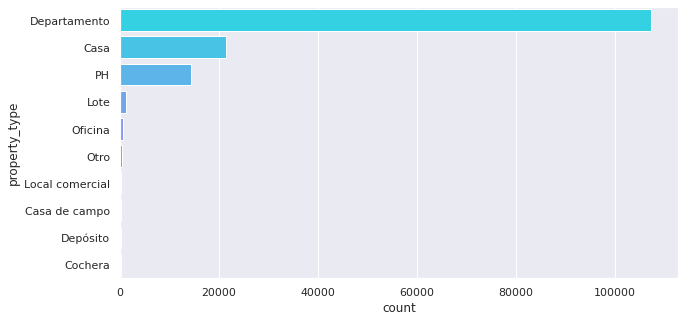

In [20]:
plt.figure(figsize = (10,5))
print(round(100*df.property_type.value_counts(dropna=False, normalize=True),2))
sns.countplot(data = df, y = 'property_type', order = df['property_type'].value_counts().index, palette='cool')

Dado que acorde a la distribución de la variable tipo de inmueble las  categorías más representativas son Departamento, Casa y PH (en conjunto representan más del 90% de las propiedades), filtraremos nuestro dataset para tener únicamente en cuenta estas 3 categorías y así tener información comparativa de los modelos con los presentados en el primer proyecto. 

**Procesamiento a aplicar:** la variable es de tipo categórico nominal, por tanto para poder incluirla en los modelos aplicaremos one hot encoding. Adicional a ello los valores faltantes podrán imputarse a partir de las variables restantes que se consideren de mayor interés (superficie y cantidad de baños, espacios y habitaciones).

### **---> Exploración variable operation_type:**

In [21]:
df.columns

Index(['start_date', 'end_date', 'created_on', 'lat', 'lon', 'l1', 'l2', 'l3',
       'rooms', 'bedrooms', 'bathrooms', 'surface_total', 'surface_covered',
       'price', 'currency', 'title', 'description', 'property_type',
       'operation_type'],
      dtype='object')

In [22]:
df.operation_type.value_counts(dropna=False)

Venta    146660
Name: operation_type, dtype: int64

La variable operation_type será descartada del total pues todos los inmuebles se encuentran en el dataset son de tipo venta, lo cual no agrega valor alguno.

## **EP. 1.3.** Eliminación de variables y filtrado de categorias de interes.

### **---> Eliminación de variables:**

Acorde a lo discutido en el numeral anterior, descartamos del total 3 tipos de variables que no resultan útiles para nuestro caso de estudio: variables que presentan atributos asociados a fechas, variables que presenta un único valor y variables con textos descriptivos. Estas variables las eliminamos en esta sección de manera definitiva.

In [23]:
# Atributos asociados a fechas
list_descartar_dates= ['start_date','end_date','created_on']
# Atributos con un único valor
list_descartar_uni_val= ['l1','currency','operation_type']
# Atributo con texto descriptivo
list_descartar_text_vdesc= ['title','description']
# Totalidad de los atributos a descartar
list_descartar = list_descartar_dates + list_descartar_uni_val + list_descartar_text_vdesc

In [24]:
# Creamos nuestro dataframe base a partir de os valores ya filtrados
df_base = df.drop(list_descartar,axis=1)
df_base

,lat,lon,l2,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,-34.605880,-58.384949,Capital Federal,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,-34.624056,-58.412110,Capital Federal,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,-34.593569,-58.427474,Capital Federal,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,-34.581294,-58.436754,Capital Federal,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
4,-34.914194,-57.938219,Bs.As. G.B.A. Zona Sur,La Plata,2.0,1.0,1.0,50.0,35.0,40000.0,PH
...,...,...,...,...,...,...,...,...,...,...,...
146655,-34.816348,-58.181963,Bs.As. G.B.A. Zona Sur,Berazategui,2.0,1.0,1.0,54.0,48.0,165000.0,Departamento
146656,-34.446459,-58.937810,Bs.As. G.B.A. Zona Norte,Pilar,4.0,3.0,2.0,164.0,90.0,130000.0,Departamento
146657,-34.444633,-58.981606,Bs.As. G.B.A. Zona Norte,Pilar,1.0,1.0,1.0,50.0,35.0,73000.0,Departamento
146658,-34.444830,-58.981796,Bs.As. G.B.A. Zona Norte,Pilar,2.0,1.0,1.0,38.0,38.0,68000.0,Departamento


### **---> Filtrado de categorías de interes:**

Acorde a lo discutido en el numeral anterior, tomaremos en cuenta únicamente las propiedades ubicadas en Capital Federal (63% del total de los registros), y las propiedades de tipo Departamento, Casa y PH (en conjunto representan el 90% del total de las propiedades). Esta muestra también nos permitirá tener un conjunto de datos comparativo respecto al primer proyecto:

In [25]:
# Filtrado de propiedades ubicadas en Capital Federal
df_base = df_base[(df_base.l2 == 'Capital Federal')]
df_base = df_base.drop(['l2'],axis=1)
# Filtrado de pripiedades de tipo Departamento, Casa y PH
df_base=df_base[df_base.property_type.isin(['Departamento','Casa','PH'])]
df_base

,lat,lon,l3,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type
0,-34.605880,-58.384949,San Cristobal,7.0,7.0,2.0,140.0,140.0,153000.0,Departamento
1,-34.624056,-58.412110,Boedo,2.0,1.0,2.0,70.0,58.0,159000.0,PH
2,-34.593569,-58.427474,Palermo,2.0,1.0,1.0,45.0,45.0,125000.0,PH
3,-34.581294,-58.436754,Palermo,2.0,1.0,1.0,85.0,50.0,295000.0,PH
5,-34.593779,-58.441239,Villa Crespo,2.0,1.0,1.0,56.0,56.0,150000.0,PH
...,...,...,...,...,...,...,...,...,...,...
146554,-34.585355,-58.427194,Palermo,4.0,3.0,3.0,175.0,111.0,570000.0,PH
146555,-34.585355,-58.427194,Palermo,3.0,2.0,2.0,144.0,134.0,480000.0,PH
146556,-34.584134,-58.436389,Palermo,4.0,2.0,2.0,317.0,143.0,530000.0,PH
146557,-34.583995,-58.417645,Palermo,3.0,2.0,2.0,145.0,145.0,420000.0,Departamento


## **EP. 1.4.** Definición del dataset base.

Finalmente reorganizamos las variables y obtenemos el dataframe base que emplearemos en la siguiente etapa de transformación.

In [26]:
df_base = df_base.reset_index(drop=True)
df_base = df_base[['l3',  'property_type', 'lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price']]

In [27]:
df_base

,l3,property_type,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
0,San Cristobal,Departamento,-34.605880,-58.384949,7.0,7.0,2.0,140.0,140.0,153000.0
1,Boedo,PH,-34.624056,-58.412110,2.0,1.0,2.0,70.0,58.0,159000.0
2,Palermo,PH,-34.593569,-58.427474,2.0,1.0,1.0,45.0,45.0,125000.0
3,Palermo,PH,-34.581294,-58.436754,2.0,1.0,1.0,85.0,50.0,295000.0
4,Villa Crespo,PH,-34.593779,-58.441239,2.0,1.0,1.0,56.0,56.0,150000.0
...,...,...,...,...,...,...,...,...,...,...
91480,Palermo,PH,-34.585355,-58.427194,4.0,3.0,3.0,175.0,111.0,570000.0
91481,Palermo,PH,-34.585355,-58.427194,3.0,2.0,2.0,144.0,134.0,480000.0
91482,Palermo,PH,-34.584134,-58.436389,4.0,2.0,2.0,317.0,143.0,530000.0
91483,Palermo,Departamento,-34.583995,-58.417645,3.0,2.0,2.0,145.0,145.0,420000.0


# **Parte A.** Trasformación de datos

In [28]:
df_A = df_base.copy()
df_A

,l3,property_type,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
0,San Cristobal,Departamento,-34.605880,-58.384949,7.0,7.0,2.0,140.0,140.0,153000.0
1,Boedo,PH,-34.624056,-58.412110,2.0,1.0,2.0,70.0,58.0,159000.0
2,Palermo,PH,-34.593569,-58.427474,2.0,1.0,1.0,45.0,45.0,125000.0
3,Palermo,PH,-34.581294,-58.436754,2.0,1.0,1.0,85.0,50.0,295000.0
4,Villa Crespo,PH,-34.593779,-58.441239,2.0,1.0,1.0,56.0,56.0,150000.0
...,...,...,...,...,...,...,...,...,...,...
91480,Palermo,PH,-34.585355,-58.427194,4.0,3.0,3.0,175.0,111.0,570000.0
91481,Palermo,PH,-34.585355,-58.427194,3.0,2.0,2.0,144.0,134.0,480000.0
91482,Palermo,PH,-34.584134,-58.436389,4.0,2.0,2.0,317.0,143.0,530000.0
91483,Palermo,Departamento,-34.583995,-58.417645,3.0,2.0,2.0,145.0,145.0,420000.0


## **A. 01.** Detección y eliminación de Outliers

La detección y eliminación de outliers se da para registros de tipo numérico ya sean de tipo discreto o continuo. En específico existen 2 tipos de criterios generales con los cuales se pueden detectar valores outliers en una distribución: el criterio de los rangos intercuartílicos y el criterio de los 3 sigmas. Ambos criterios son empleados de manera conjunta en esta sección para determinar los que valores consideraremos outliers y filtrarlos del dataset de análisis que emplearemos para nuestros modelos de predicción, esto hará que nuestros modelos se centren más en el comportamiento de los valores que se consideran representativos dentro de cada distribución.

### ---> Selección de features a aplicar detección y eliminación de outliers

Inicialmente definimos las columnas sobre las cuales haremos el proceso de  detección y eliminación de outliers. Como fue mencionado estas se generan sobre las columnas de tipo numérico:

In [29]:
col_outliers=['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms',
       'surface_total', 'surface_covered', 'price']

### ---> Definición de funciones que nos permiten detectar outliers:

En esta sección se presentan de manera específica 4 funciones que nos permiten detectar outliers: 
1. **Indx_outlier_rang_int:** la función implementa el criterio del rango intercuartílico para entregarnos como salida el conjunto de índices que se consideran outliers a partir de una serie que recibe como entrada.
2. **Indx_outlier_3_sig:** la función implementa el criterio los 3 sigmas para entregarnos como salida el conjunto de índices que se consideran outliers a partir de una serie que recibe como entrada.
3. **indx_outlier_mix:** la función implementa conjuntamente el criterio del rango intercuartílico y de los 3 sigmas para entregarnos como salida el conjunto de índices que se consideran outliers a partir de una serie que recibe como entrada.
4. **Indx_outlier_mix_df:** la función implementa conjuntamente el criterio del rango intercuartílico y de los 3 sigmas para entregarnos como salida el conjunto de índices que se consideran outliers a partir de un dataframe y una lista de columnas que recibe como entrada. Las columnas corresponden a las columnas en las cuales se detecten los valores outliers.


In [30]:
# Definimos una función que retorna los indices de los registros que se consideran outlier
# (Bajo el criterio basado en el rango intercuartilico)
# Entrada: la serie de la que deseamos encontrar outlayers
# Salida: Los indices que de los outliers en la serie
def indx_outlier_rang_int(series):
    q75=series.quantile(0.75)
    q25=series.quantile(0.25)
    iqr = q75 - q25
    minimo = q25 - 1.5*iqr
    maximo = q75 + 1.5*iqr
    mascara_outliers = (series < minimo) | (series > maximo)
    return list(series[mascara_outliers].index)

In [31]:
# Definimos una función que retorna los indices de los registros que se consideran outliers
# (Bajo el criterio de las tres sigmas)
# Entrada: la serie de la que deseamos encontrar outliers
# Salida: Los indices que de los outliers en la serie
def indx_outlier_3_sig(series):
    valor_medio = series.mean()
    std = series.std()
    minimo = valor_medio - 3*std
    maximo = valor_medio + 3*std
    mascara_outliers = (series < minimo) | (series > maximo)
    return list(series[mascara_outliers].index)

In [32]:
# Definimos una función que retorna los indices de los registros que se consideran outliers
# (Empleando simultaneamento los criterios de rango intercuartilico y de los 3 sigmas)
# Entrada: la serie de la que deseamos encontrar outliers
# Salida: Los indices que de los outliers en la serie
def indx_outlier_mix(series):
    return sorted(list(set(indx_outlier_rang_int(series)+indx_outlier_3_sig(series))))

In [33]:
# Definimos una función que nos entrega la totalidad de los indices de outliers teniendo en cuenta varias columnas
# Entradas: dataframe del que deseamos encontrar los outliers
# Salidas: columnas del dataframe de las que nos interesa que haga el analisis de outliers
def indx_outlier_mix_df(df,col_outliers):
    indx_total=[]
    for col in col_outliers:
        indx = indx_outlier_mix(df[col])
        indx_total=indx_total+indx
    return sorted(list(set(indx_total)))

### ---> Dataframe procesado sin outliers

A partir de las funciones definidas procedemos a encontrar y a eliminar los índices que se consideran outliers en nuestro dataframe de estudio (en nuestro caso específico se encontro que el porcentaje total de valores atipicos encontrados es de 13.52%). Este dataframe sera el que emplearemos como entrada en el siguiente proceso de transformación.

In [34]:
indx_outlier_total = indx_outlier_mix_df(df_A,col_outliers)

In [35]:
# Calculamos el porcentaje de valores del dataframe que se consideran outliers
round(100*len(indx_outlier_total)/len(df_A),2)

13.52

In [36]:
# Finalmente obtendriamos el dataframe filtrado para sin los valores que consideramos outliers
df_A_no_outliers= df_base.drop(indx_outlier_total).reset_index(drop=True)
df_A_no_outliers

,l3,property_type,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price
0,Boedo,PH,-34.624056,-58.412110,2.0,1.0,2.0,70.0,58.0,159000.0
1,Palermo,PH,-34.593569,-58.427474,2.0,1.0,1.0,45.0,45.0,125000.0
2,Palermo,PH,-34.581294,-58.436754,2.0,1.0,1.0,85.0,50.0,295000.0
3,Villa Crespo,PH,-34.593779,-58.441239,2.0,1.0,1.0,56.0,56.0,150000.0
4,Villa Crespo,PH,-34.600988,-58.433061,2.0,1.0,1.0,70.0,70.0,159500.0
...,...,...,...,...,...,...,...,...,...,...
79108,Palermo,Departamento,NaN,NaN,3.0,2.0,2.0,82.0,82.0,475000.0
79109,Palermo,PH,-34.576573,-58.434394,3.0,2.0,1.0,84.0,84.0,178000.0
79110,Palermo,PH,NaN,NaN,5.0,2.0,2.0,114.0,95.0,298000.0
79111,Palermo,PH,-34.585355,-58.427194,3.0,2.0,2.0,144.0,134.0,480000.0


## **A. 02.** Encoding

El proceso de encoding se da para atributos de tipo categórico que sean nominales u ordinales. En específico para los atributos de tipo categórico nominal se presenta el proceso de *one hot encoding*, y para los atributos de tipo categórico ordinal se puede presentar tanto *one hot encoding* cómo *label encoding* según sea útil en cada caso de estudio. Dado que nuestro dataset cuenta únicamente con atributos de tipo categórico nominal solo implementaremos el proceso de *one hot encoding*. Este proceso es obligatorio, pues los modelos reciben únicamente como entradas variables de  variables de tipo numérico.

### ---> Selección de features a aplicar encoding

Inicialmente definimos las columnas sobre las cuales haremos el proceso de encoding. Como fue mencionado estas se generan sobre las columnas de tipo categórico:

In [37]:
col_encoding=['property_type', 'l3']

### ---> Definición de funciones que nos permiten generar el encoding:

Para desarrollar el proceso de one hot encoding la librería **pandas** cuenta con la función **get_dummies** que nos permite implementar de manera directa el one hot encoding. 

### ---> Dataframe procesado con encoding

A partir de la función descrita obtenemos el dataframe con el encoding implementado. Este dataframe sera el que emplearemos como entrada en el siguiente proceso de transformación.

In [38]:
df_A_encode = pd.get_dummies(df_A_no_outliers, columns=col_encoding, drop_first=False)
df_A_encode

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,l3_Abasto,l3_Agronomía,l3_Almagro,l3_Balvanera,l3_Barracas,l3_Barrio Norte,l3_Belgrano,l3_Boca,l3_Boedo,l3_Caballito,l3_Catalinas,l3_Centro / Microcentro,l3_Chacarita,l3_Coghlan,l3_Colegiales,l3_Congreso,l3_Constitución,l3_Flores,l3_Floresta,l3_Las Cañitas,l3_Liniers,l3_Mataderos,l3_Monserrat,l3_Monte Castro,l3_Nuñez,l3_Once,l3_Palermo,l3_Parque Avellaneda,l3_Parque Centenario,l3_Parque Chacabuco,l3_Parque Chas,l3_Parque Patricios,l3_Paternal,l3_Pompeya,l3_Puerto Madero,l3_Recoleta,l3_Retiro,l3_Saavedra,l3_San Cristobal,l3_San Nicolás,l3_San Telmo,l3_Tribunales,l3_Velez Sarsfield,l3_Versalles,l3_Villa Crespo,l3_Villa Devoto,l3_Villa General Mitre,l3_Villa Lugano,l3_Villa Luro,l3_Villa Ortuzar,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque
0,-34.624056,-58.412110,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-34.593569,-58.427474,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-34.581294,-58.436754,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-34.593779,-58.441239,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,-34.600988,-58.433061,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
79108,NaN,NaN,3.0,2.0,2.0,82.0,82.0,475000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
79109,-34.576573,-58.434394,3.0,2.0,1.0,84.0,84.0,178000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
79110,NaN,NaN,5.0,2.0,2.0,114.0,95.0,298000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
79111,-34.585355,-58.427194,3.0,2.0,2.0,144.0,134.0,480000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **A. 03.** Imputación de valores faltantes

Al momento de presentarse registros con parámetros nulos existen múltiples técnicas para tratarlos, entre estos 2 principales: la eliminación de los valores o su imputación. Cada uno acorde al problema específico debe implementarse a criterio evaluando los pros y contras que conlleva su implementación. El proceso de imputación o eliminación de valores faltantes es obligatorio, pues los modelos no reciben como entrada valores nulos. En nuestro caso específico describiremos cuando implementaremos uno u otro para cada parámetro.

In [39]:
# Observamos inicialmente que parametros presentan valores nulos
df_A_no_outliers.isnull().sum()

l3                    0
property_type         0
lat                3449
lon                3460
rooms                 0
bedrooms              0
bathrooms          1999
surface_total      8209
surface_covered    8476
price                 0
dtype: int64

### ---> Registros que no se imputaran (se eliminaran si son nulos)

En nuestra implementación definiremos un conjunto de casos específicos en los cuales no imputamos los valores sino que los eliminaremos de antemano, esto dado que la imputación puede generar valores que carezcan de sentido,  siendo finalmente poco fiable imputarlos a partir de otros parámetros. Estos seran los casos para los cuales no imputaremos sino que eliminaremos los registros: 
- **Registros que presentan valores nulos en las variables lat o lon:** no los imputaremos pues son variables completamente específicas e identitarias para cada inmueble. 
- **Registros que presentan valores nulos en las surface_total y surface_covered:** no los imputaremos pues la superficie es un parámetro determinante en relación con el precio. Si no conocemos ni la superficie construida ni la superficie total, estimar un valor de área a partir de otros parámetros puede ser poco objetivo. Ahora, en el caso que se conozca uno de los 2 puede resultar útil obtenerlo a partir del otro.


In [40]:
# Indices de los registros a eliminar por lat o lon nula
indx_to_drop_01 = df_A_encode[(df_A_encode.lat.isnull()==True)|(df_A_encode.lon.isnull()==True)].index
# Indices de los registros a eliminar por surface_total o surface_covered nula
indx_to_drop_02 = df_A_encode[(df_A_encode.surface_total.isnull()==True)&(df_A_encode.surface_covered.isnull()==True)].index
# Indices totales a dropear
indx_to_drop_total = indx_to_drop_01 | indx_to_drop_02

In [41]:
df_A_droped = df_A_encode.drop(indx_to_drop_total).reset_index(drop=True)
df_A_droped

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,l3_Abasto,l3_Agronomía,l3_Almagro,l3_Balvanera,l3_Barracas,l3_Barrio Norte,l3_Belgrano,l3_Boca,l3_Boedo,l3_Caballito,l3_Catalinas,l3_Centro / Microcentro,l3_Chacarita,l3_Coghlan,l3_Colegiales,l3_Congreso,l3_Constitución,l3_Flores,l3_Floresta,l3_Las Cañitas,l3_Liniers,l3_Mataderos,l3_Monserrat,l3_Monte Castro,l3_Nuñez,l3_Once,l3_Palermo,l3_Parque Avellaneda,l3_Parque Centenario,l3_Parque Chacabuco,l3_Parque Chas,l3_Parque Patricios,l3_Paternal,l3_Pompeya,l3_Puerto Madero,l3_Recoleta,l3_Retiro,l3_Saavedra,l3_San Cristobal,l3_San Nicolás,l3_San Telmo,l3_Tribunales,l3_Velez Sarsfield,l3_Versalles,l3_Villa Crespo,l3_Villa Devoto,l3_Villa General Mitre,l3_Villa Lugano,l3_Villa Luro,l3_Villa Ortuzar,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque
0,-34.624056,-58.412110,2.0,1.0,2.0,70.0,58.0,159000.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,-34.593569,-58.427474,2.0,1.0,1.0,45.0,45.0,125000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,-34.581294,-58.436754,2.0,1.0,1.0,85.0,50.0,295000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,-34.593779,-58.441239,2.0,1.0,1.0,56.0,56.0,150000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,-34.600988,-58.433061,2.0,1.0,1.0,70.0,70.0,159500.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67863,-34.587152,-58.437724,3.0,2.0,2.0,120.0,82.0,430000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67864,-34.581425,-58.442707,3.0,2.0,2.0,88.0,82.0,399000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67865,-34.576573,-58.434394,3.0,2.0,1.0,84.0,84.0,178000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67866,-34.585355,-58.427194,3.0,2.0,2.0,144.0,134.0,480000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


### ---> Registros que se imputaran a partir de otros

Existen múltiples maneras de imputar registros en el caso en que estimamos que otros parámetros son útiles para estimar los valores faltantes:imputación mediante valores medios, medianas, modas, diversos tipos de regresores, entre otros. En nuestro caso especifico implementaremos una función que hará uso del imputer basado en KNN de ScikitLearn. Esta función nos permitirá obtener información a partir de un dataframe de entrada y de una lista de columnas, el mismo dataframe pero ahora con las columnas elegidas ya imputadas. Así podremos tener la libertad de elegir qué variables en especifico elegir para hacer la imputación de las restantes.

Con dicha función imputamos 2 tipos de conjuntos valores en específico: 
- **Valores de surface_total y surface_covered:** los registros en los cuales se conoce un tipo de superficie y no la otra las imputaremos entre sí. 
- **Valores de bathrooms:** imputaremos estos registros nulos a partir de las variables rooms y bedrooms. Lo lógico es que estas dos variables asociadas a la cantidad de espacios distribuidos en viviendas tengan relación con la variable bathrooms.


In [42]:
# Inicialmente evaluamos las columnas que presentan valores a imputar
df_A_droped[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price']].isnull().sum()

lat                  0
lon                  0
rooms                0
bedrooms             0
bathrooms          760
surface_total      173
surface_covered    434
price                0
dtype: int64

In [43]:
# Función que nos permite hacer la imputación de columnas especificas de un dataframe
def fun_knn_imputer(df,columns):
    df_imputed=df.copy()
    knn_imputer = KNNImputer(n_neighbors=10, weights="distance")
    array_imputed = knn_imputer.fit_transform(df[columns])
    df_imputed_columns = pd.DataFrame(data=array_imputed, columns=df[columns].columns, index=df[columns].index)
    df_imputed[columns]=df_imputed_columns
    return df_imputed

In [44]:
# Dataframe imputado para las variables de superficie
df_A_imputed = fun_knn_imputer(df_A_droped,['surface_total','surface_covered'])
# Dataframe imputado para la variable de bathrooms
df_A_imputed = fun_knn_imputer(df_A_imputed,['rooms', 'bedrooms', 'bathrooms'])

In [45]:
# Corroboramos que no existen ahora varibles nulas en el dataset
df_A_imputed[['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered', 'price']].isnull().sum()

lat                0
lon                0
rooms              0
bedrooms           0
bathrooms          0
surface_total      0
surface_covered    0
price              0
dtype: int64

## **A. 04.** Escalado de datos

De la misma manera que en la sección anterior existen múltiples maneras de escalar los valores de nuestros features: standart scaler, normalización, min-max scaler, entre otros. En nuestro caso especifico implementaremos dos funciones que nos permitirán implementar escaladores basados en  función de los escaladores  standart scaler de ScikitLearn, y por otra parte una función de escalado logarítmico implementado de manera propia. El escalado es un proceso determinante pues estará relacionado en varios modelos con la importancia que puede tener cada feature dentro de la predicción. El escalado permitirá tener una importancia relativa para cada uno de los features involucrados. El dataframe se escalará de manera conjunta con los 3 escaladores.
 
Cada uno de los tipos de escaladores se emplearán de la siguiente manera:
- **Escalador logarítmico:** cuando la distribución de cierta variable presenta una larga cola el escalador logarítmico resulta útil. Esto permite al modelo discriminar de mejor manera en relación con este parámetro en específico. Estos tipos de distribuciones los podemos encontrar en las variables surface_total y surface_covered a los cuales los aplicaremos.
- **Escalador basado en standard scaler:** Lo aplicaremos a todas las variables numéricas del dataset.
- **Escalador basado en minmax scaler:** Lo aplicaremos a todas las variables numéricas del dataset.


In [46]:
# Función que me permite escalar logaritmicamente
# Entradas: df (dataframe que quiero escalar, col (lista con las columnas que deseo escalar))
# Salida: dataframe escalado en las columnas que se pidio (mantiene indices de filas y columnas)
def fun_scaler_logaritmic(df,columns):
    df_scaled=df.copy()
    df_scaled[columns]=df_scaled[columns].applymap(lambda x: np.log(x+1))
    return df_scaled

In [47]:
# Función que me permite escalar empleando el MinMaxScaler
# Entradas: df (dataframe que quiero escalar, col (lista con las columnas que deseo escalar))
# Salida: dataframe escalado en las columnas que se pidio (mantiene indices de filas y columnas)
def fun_scaler_standar(df,columns):
    df_scaled=df.copy()
    std_scaler = StandardScaler()
    array_scaled=std_scaler.fit_transform(df[columns])
    df_scaled_columns = pd.DataFrame(data=array_scaled, columns=df[columns].columns, index=df[columns].index)
    df_scaled[columns]=df_scaled_columns
    return df_scaled

In [48]:
# Función que me permite escalar empleando el StandarScaler
# Entradas: df (dataframe que quiero escalar, col (lista con las columnas que deseo escalar))
# Salida: dataframe escalado en las columnas que se pidio (mantiene indices de filas y columnas)
def fun_scaler_minmax(df,columns):
    df_scaled=df.copy()
    minmax_scaler = MinMaxScaler()
    array_scaled=minmax_scaler.fit_transform(df[columns])
    df_scaled_columns = pd.DataFrame(data=array_scaled, columns=df[columns].columns, index=df[columns].index)
    df_scaled[columns]=df_scaled_columns
    return df_scaled

In [49]:
# Dataframe escalado con el escalador logarítmico
df_A_scaled = fun_scaler_logaritmic(df_A_imputed,['surface_total','surface_covered'])
# Dataframe escalado con el standard_scaler
df_A_scaled = fun_scaler_standar(df_A_scaled,['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered'])
# Dataframe escalado con el escalador minmax_scaler
df_A_scaled = fun_scaler_minmax(df_A_scaled,['lat', 'lon', 'rooms', 'bedrooms', 'bathrooms', 'surface_total',
       'surface_covered'])
df_A_scaled

,lat,lon,rooms,bedrooms,bathrooms,surface_total,surface_covered,price,property_type_Casa,property_type_Departamento,property_type_PH,l3_Abasto,l3_Agronomía,l3_Almagro,l3_Balvanera,l3_Barracas,l3_Barrio Norte,l3_Belgrano,l3_Boca,l3_Boedo,l3_Caballito,l3_Catalinas,l3_Centro / Microcentro,l3_Chacarita,l3_Coghlan,l3_Colegiales,l3_Congreso,l3_Constitución,l3_Flores,l3_Floresta,l3_Las Cañitas,l3_Liniers,l3_Mataderos,l3_Monserrat,l3_Monte Castro,l3_Nuñez,l3_Once,l3_Palermo,l3_Parque Avellaneda,l3_Parque Centenario,l3_Parque Chacabuco,l3_Parque Chas,l3_Parque Patricios,l3_Paternal,l3_Pompeya,l3_Puerto Madero,l3_Recoleta,l3_Retiro,l3_Saavedra,l3_San Cristobal,l3_San Nicolás,l3_San Telmo,l3_Tribunales,l3_Velez Sarsfield,l3_Versalles,l3_Villa Crespo,l3_Villa Devoto,l3_Villa General Mitre,l3_Villa Lugano,l3_Villa Luro,l3_Villa Ortuzar,l3_Villa Pueyrredón,l3_Villa Real,l3_Villa Santa Rita,l3_Villa Soldati,l3_Villa Urquiza,l3_Villa del Parque
0,0.286838,0.670438,0.2,0.2,0.5,0.637508,0.756857,159000.0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,0.544692,0.583409,0.2,0.2,0.0,0.489125,0.701196,125000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,0.648512,0.530842,0.2,0.2,0.0,0.703033,0.724271,295000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,0.542915,0.505438,0.2,0.2,0.0,0.562424,0.749145,150000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
4,0.481941,0.551759,0.2,0.2,0.0,0.637508,0.798261,159500.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
67863,0.598966,0.525348,0.4,0.4,0.5,0.819761,0.833183,430000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67864,0.647402,0.497120,0.4,0.4,0.5,0.714755,0.833183,399000.0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67865,0.688442,0.544209,0.4,0.4,0.0,0.699034,0.838508,178000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
67866,0.614165,0.584997,0.4,0.4,0.5,0.881620,0.941965,480000.0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


## **A. 05.** Generación de nuevas variables predictoras (reducción de dimensionalidad SVD/PCA)

Dado que queremos comparar los valores obtenidos por los modelos del primer proyecto con los valores obtenidos en este, y que los modelos que emplearon (regresor lineal, árbol de decisión y KNN) permitían conservar la interpretabilidad en relación con los features, no implementaremos SVD o PCA, pues aunque los resultados de los modelos puedan mejorar, nuestro enfoque es comparativo y no es útil perder la interpretabilidad en relación a las variables.

## **A. 06.** Comparación resultados de los modelos (Proyecto 01 Vs Proyecto actual)

Con el fin de evaluar cuál es la variación en las métricas de los modelos implementados en el primer proyecto PY_01 (regresor lineal, árbol de decisión y KNN) ser evaluaran los modelos bajo las mismas condiciones (iguales hiperparametros) y variando únicamente el dataset de entrada al cual hemos hecho todas las transformaciones y para el cual hemos incluido ahora variables adicionales.

### ---> Definición de las nuevas variables predictoras

In [50]:
X = df_A_scaled.drop('price', axis=1)
y = df_A_scaled['price']

### ---> Train-Test Split (iguales parámetros PY_01)

In [51]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(47507, 66) (47507,) (20361, 66) (20361,)


### ---> Modelos instanciados (iguales hiperparametros PY_01)

In [52]:
linear_model = LinearRegression()
tree_regressor = DecisionTreeRegressor(max_depth=3, random_state=42)
knn_regressor = KNeighborsRegressor(n_neighbors=5)

### ---> Entrenamiento de los modelos

In [53]:
linear_model.fit(X_train, y_train)
tree_regressor.fit(X_train, y_train)
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor()

### ---> Resultados de los modelos (iguales hiperparámetros PY_01 - nuevo dataframe)

Modelo: Regresión lineal
Raíz del error cuadrático medio en Train: 44143.814088767176
Raíz del error cuadrático medio en Test: 44214.72941966836
R cuadrado en Train: 0.7699301113282079
R cuadrado en Test: 0.7721363026987982


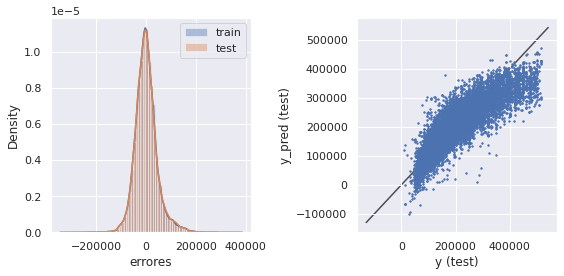

Modelo: Árbol de Decisión
Raíz del error cuadrático medio en Train: 54385.93455461426
Raíz del error cuadrático medio en Test: 54646.03060024996
R cuadrado en Train: 0.6507846978947374
R cuadrado en Test: 0.6519365355152797


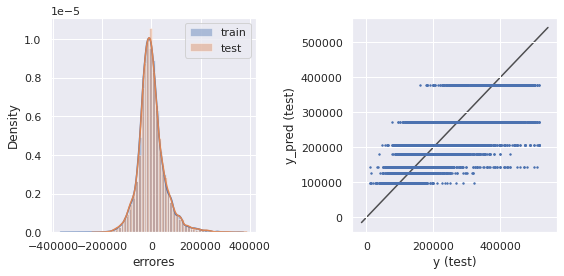

Modelo: Vecinos más cercanos
Raíz del error cuadrático medio en Train: 27324.48220330548
Raíz del error cuadrático medio en Test: 34264.592004360675
R cuadrado en Train: 0.9118496672883556
R cuadrado en Test: 0.863153930969198


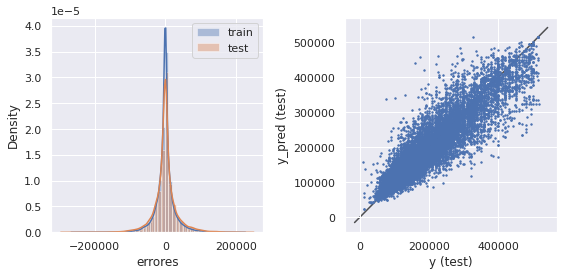

In [54]:
modelos = ['Regresión lineal', 'Árbol de Decisión', 'Vecinos más cercanos']

for i, model in enumerate([linear_model, tree_regressor, knn_regressor]):
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    
    print(f'Modelo: {modelos[i]}')

    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f'R cuadrado en Train: {r2_train}')
    print(f'R cuadrado en Test: {r2_test}')
    
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 50, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 50, label = 'test')
    plt.xlabel('errores')
    plt.legend()


    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

In [55]:
resultados_PY_01 = {'Modelo': ['Regresión lineal', 'Árbol de Decisión', 'Vecinos más cercanos'], 
                    'RMSE_Train': [199173.83253528475, 191783.485243933, 121300.24049431273], 
                    'RMSE_Test': [202449.36540361575, 194688.15091192327, 155040.1332898459], 
                    'R2_Train': [0.5517887107017188, 0.5844333913686437, 0.8337576939918325],
                    'R2_Test': [0.5514864358797202, 0.5852162030595955, 0.7369544202301519]
                    }
                    
resultados_PY_02 = {'Modelo': ['Regresión lineal', 'Árbol de Decisión', 'Vecinos más cercanos'], 
                    'RMSE_Train': [44143.814088767176, 54385.93455461426, 27331.957836355217], 
                    'RMSE_Test': [44214.72941966836, 54646.03060024996, 34287.79193709084], 
                    'R2_Train': [0.7699301113282079, 0.6507846978947374, 0.9118014270560322],
                    'R2_Test': [0.7721363026987982, 0.6519365355152797, 0.8629685562592448]
                    }

### ---> Evaluación comparativa entre los resultados del PY_01 y el proyecto actual

In [56]:
df_resultados_PY_01 = pd.DataFrame.from_dict(resultados_PY_01)
df_resultados_PY_01['Proyecto']='PY_01'
df_resultados_PY_01 = df_resultados_PY_01[['Modelo', 'Proyecto', 'RMSE_Train', 'RMSE_Test', 'R2_Train', 'R2_Test']]
df_resultados_PY_01[['R2_Train', 'R2_Test']] = df_resultados_PY_01[['R2_Train', 'R2_Test']]

df_resultados_PY_02 = pd.DataFrame.from_dict(resultados_PY_02)
df_resultados_PY_02['Proyecto']='PY_02'
df_resultados_PY_02 = df_resultados_PY_02[['Modelo', 'Proyecto', 'RMSE_Train', 'RMSE_Test', 'R2_Train', 'R2_Test']]
df_resultados_PY_02[['R2_Train', 'R2_Test']] = df_resultados_PY_02[['R2_Train', 'R2_Test']]

In [57]:
df_resultados_compilados = pd.concat([df_resultados_PY_01,df_resultados_PY_02]).sort_values(by='Modelo', ascending=False).reset_index(drop=True)
df_resultados_compilados

,Modelo,Proyecto,RMSE_Train,RMSE_Test,R2_Train,R2_Test
0,Árbol de Decisión,PY_01,191783.485244,194688.150912,0.584433,0.585216
1,Árbol de Decisión,PY_02,54385.934555,54646.030600,0.650785,0.651937
2,Vecinos más cercanos,PY_01,121300.240494,155040.133290,0.833758,0.736954
3,Vecinos más cercanos,PY_02,27331.957836,34287.791937,0.911801,0.862969
4,Regresión lineal,PY_01,199173.832535,202449.365404,0.551789,0.551486
5,Regresión lineal,PY_02,44143.814089,44214.729420,0.769930,0.772136


In [58]:
list_delta_arbol = list(df_resultados_compilados.iloc[1, 2:6]-df_resultados_compilados.iloc[0, 2:6])
list_delta_knn = list(df_resultados_compilados.iloc[3, 2:6]-df_resultados_compilados.iloc[2, 2:6])
list_delta_lineal = list(df_resultados_compilados.iloc[5, 2:6]-df_resultados_compilados.iloc[4, 2:6])

df_resultados_variacion = pd.DataFrame(list(zip(list_delta_arbol, list_delta_knn, list_delta_lineal)),
               columns = ['Árbol de Decisión', 'Vecinos más cercanos', 'Regresión lineal']).T
df_resultados_variacion.columns = ['Dif_RMSE_Train', 'Dif_RMSE_Test', 'Dif_R2_Train', 'Dif_R2_Test']              
df_resultados_variacion

,Dif_RMSE_Train,Dif_RMSE_Test,Dif_R2_Train,Dif_R2_Test
Árbol de Decisión,-137397.550689,-140042.120312,0.066351,0.066720
Vecinos más cercanos,-93968.282658,-120752.341353,0.078044,0.126014
Regresión lineal,-155030.018447,-158234.635984,0.218141,0.220650


En la presente sección hemos encontrado las variaciones que presentan  modelos de proyecto PY_01 (regresor lineal, árbol de decisión y KNN) únicamante a partir de la variación de dataset de entrada. En general todos los modelos mejoran sus métricas (RMSE y R2) tanto en el conjunto de test como en el conjunto de train. Los incrementos en el valor de R2 se dan en un rango entre un  6% y un 22%, con una mejora mucho más significativa en el modelo de regresión lineal.

Puede observarse de igual manera que la mejora no se da únicamente en relación con las métricas, sino con la distribución de sus errores, presentando un comportamiento mucho más homocedástico en la nueva distribución. 

Como principales elementos en la contribución a la mejora en los resultados tanto de las métricas como de la distribución de sus errores podemos destacar los siguientes:
- **Eliminación de outliers:** permite que el aprendizaje de los modelos se centre en los registros representativos de las distribuciones y no en los valores con comportamientos alejados de las mismas.
- **Encoding:** permitió incluir en el modelo variables categóricas que antes no existían (los barrios específicamente que pueden ser una característica determinante en la estimación del modelo.
- **Imputación de valores faltantes:** permitió por una parte prescindir de valores que podrían sesgar las estimaciones en el caso de ser imputados, y por otra parte imputar algunos que teniendo un sentido lógico en su estimación iban a enriquecer en cantidad de registros el dataset. Al tener más registros representativos el aprendizaje del modelo puede incrementar mejorando con ello sus métricas. 
- **Escalado de los valores:** permite al modelo tener un equilibrio en relación a las variables con respecto a las cuales hace su predicción haciendo una estimación mucho más homogénea de la importancia que toma cada una de las variables tanto en el aprendizaje como en la evaluación.


# **Parte B.** Modelos Avanzados

En la presente sección implementaremos algunos modelos complementarios basados en técnicas de ensamble, en particular Bagging y Boosting. En específico los modelos implementados son XGBoost y Random Forest Regressor. Para cada uno de ellos evaluaremos inicialmente los resultados que nos entregan con los hiperparametros asignados por defecto en cada una de sus librerías. De manera posterior haremos una optimización de sus hiperparámetros a través de métodos de grilla y evaluaremos el desempeño de los modelos obtenidos.

### ---> Función de evaluación para los modelos

Con el fin de evaluar los modelos de manera homogénea definimos a continuación una función que nos permite calcular las métricas de R2 y RMSE, así como las gráficas de dispersión de errores para cada uno de los modelos. Emplearemos dicha función al final de cada sección para obtener los valores de rendimiento de cada modelo.

In [59]:
def evaluar_modelo(modelo, y_train, y_test, y_train_pred, y_test_pred):

    print('El modelo a evaluar: ', modelo)
    ### CALCULAMOS EL ERROR
    
    rmse_train = np.sqrt(mean_squared_error(y_train, y_train_pred))
    rmse_test = np.sqrt(mean_squared_error(y_test, y_test_pred))
    print(f'Raíz del error cuadrático medio en Train: {rmse_train}')
    print(f'Raíz del error cuadrático medio en Test: {rmse_test}')
    
    r2_train = r2_score(y_train, y_train_pred)
    r2_test = r2_score(y_test, y_test_pred)
    print(f'R cuadrado en Train: {r2_train}')
    print(f'R cuadrado en Test: {r2_test}')

    # print(f'Porcentaje del Error Absoluto medio en Train: {mape_train}')
    # print(f'Porcentaje del Error Absoluto medio en Test: {mape_test}\n')
    
        ### GRAFICAMOS LOS RESULTADOS
      
    plt.figure(figsize = (8,4))

    plt.subplot(1,2,1)
    sns.distplot(y_train - y_train_pred, bins = 20, label = 'train')
    sns.distplot(y_test - y_test_pred, bins = 20, label = 'test')
    plt.xlabel('errores')
    plt.legend()

    ax = plt.subplot(1,2,2)
    ax.scatter(y_test,y_test_pred, s =2)
    
    lims = [
    np.min([ax.get_xlim(), ax.get_ylim()]),  # min of both axes
    np.max([ax.get_xlim(), ax.get_ylim()]),  # max of both axes]
    ]
    
    ax.plot(lims, lims, 'k-', alpha=0.75, zorder=0)
    plt.xlabel('y (test)')
    plt.ylabel('y_pred (test)')
    
    plt.tight_layout()
    plt.show()

    return rmse_train, rmse_test, r2_train, r2_test

## **B. 01.** Modelos avanzados (argumentos por defecto)

En la presente sección evaluaremos los modelos de random XGBoost y Forest Regressor con los hiperparámetros que tienen asignados en su librerías por defecto. Los resultados serán evaluados de manera directa y también empleando la técnica de Cross Validation.

### **B.01.01** XGBoost (argumentos por defecto)

#### ----> Entrenamiento y evaluación

In [60]:
# # Instanciamos el modelo con sus caracteristicas por defecto
# XGB_model = xgb.XGBRegressor()

In [61]:
# # Corroboramos los hiperparametros que el modelo presenta
# XGB_model

In [62]:
# # Hacemos que el modelo se entrene con el set de entrenamiento (X_train, y_train)
# # Caracteristicas: 
# # evalset : el modelo evaluara las métricas mape y rmse y se detendra tras 50 iteraciones
# # en las que el modelo ho haya logrado obtener una metrica más baja. 
# # evalmetric: serán las metricas que emplearemos para evaluar lo pasos del del entrenamiento.
# # La última de ellas es la que se constituye como criterio de parada para elearly stopping. 
# # early_stopping_rounds: cantidad de rondas que avanzará sin (si incluimos este parameto se almacenará el mejor modelo respecto a la metrica de evaluación)
# # (Sino el modelo evaluará hasta el valor n_estimators y tomnara el valor del ultimo estimador)
# # Verbose: Imprimirá cada una de los pasos del entrenamiento con sus respectivas evaluaciones sobre el eval_set
# XGB_model.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
#         eval_metric= ['rmse'],
#         early_stopping_rounds=100,
#         verbose=1
#        )

In [63]:
# Cargado del modelo guardado (una vez ya ha sido entrenado)
path_XGB_model = '/content/drive/MyDrive/Colab Notebooks/00_Acamica/XGB_model.sav'
XGB_model = pickle.load(open(path_XGB_model, 'rb'))

In [64]:
# Visualizamos el mejor valor para la métrica de criterio de entrenamiento
XGB_model.best_score

32175.525391

In [65]:
# Visualizamos cual fue la mejor iteración en la que dicho valor se obtuvo
XGB_model.best_iteration

99

In [66]:
# Generamos la predicción con el modelo entrenado
y_train_pred = XGB_model.predict(X_train)
y_test_pred= XGB_model.predict(X_test)

El modelo a evaluar:  XGBoost (parametros por defecto)
Raíz del error cuadrático medio en Train: 28005.652518335588
Raíz del error cuadrático medio en Test: 32175.555797713354
R cuadrado en Train: 0.9073998977854276
R cuadrado en Test: 0.8793316673319217


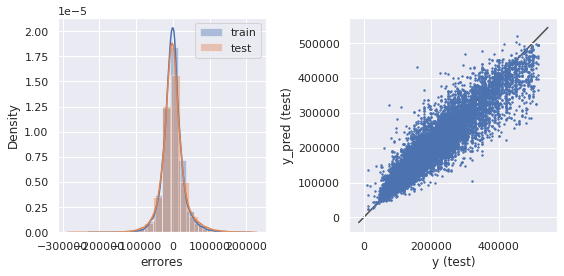

In [67]:
# Evaluamos los resultados obtenidos por el modelo
rmse_train, rmse_test, r2_train, r2_test = evaluar_modelo('XGBoost (parametros por defecto)', y_train, y_test, y_train_pred, y_test_pred)

In [68]:
# Almacenamos los resultados obtenidos por el modelo
resultados_PY_02_XGB_model = {'Modelo': ['XGBoost'], 
                              'RMSE_Train': [rmse_train], 
                              'RMSE_Test': [rmse_test], 
                              'R2_Train': [r2_train],
                              'R2_Test': [r2_test]
                              }

In [69]:
# # Guardado del modelo ya entrenado
# path_XGB_model = '/content/drive/MyDrive/Colab Notebooks/00_Acamica/XGB_model.sav'
# pickle.dump(XGB_model, open(path_XGB_model, 'wb'))

#### ---> Cross Validation

Mediante la técnica de Cross Validation corroboramos que el valor obtenido para las métricas es el valor representativo indiferente del conjunto de train y test seleccionado.

In [70]:
# CV_XGBoost_results = cross_validate(XGB_model, X_test, y_test, cv=5, scoring=['r2', 'neg_root_mean_squared_error'], return_train_score=True,  n_jobs=-1)
# CV_XGBoost_results

In [71]:
# CV_XGBoost_R2 = CV_XGBoost_results['test_r2']
# CV_XGBoost_RMSE = CV_XGBoost_results['test_neg_root_mean_squared_error']

In [72]:
# print('Modelo evaluado bajo Cross Validation:  XGBoost (parámetros por defecto)')
# print("Raíz del error cuadrático medio para test : %0.2f (+/- %0.2f)" % (abs(CV_XGBoost_RMSE.mean()), abs(CV_XGBoost_RMSE.std()) * 2))
# print("R cuadrado para test : %0.2f (+/- %0.2f)" % (abs(CV_XGBoost_R2.mean()), abs(CV_XGBoost_R2.std()) * 2))

### **B.01.02** Random Forest (argumentos por defecto)

#### ----> Entrenamiento y evaluación

In [73]:
# # Instanciaremos el modelo con sus caracteristicas por defecto
# RFR_Model = RandomForestRegressor()

In [74]:
# # Corroboramos los hiperparametros que el modelo presenta
# RFR_Model

In [75]:
# # Hacemos que el modelo se entrene con el set de entrenamiento (X_train, y_train)
# RFR_Model.fit(X_train,y_train)

In [76]:
# Cargado del modelo guardado (una vez ya ha sido entrenado)
path_RFR_Model = '/content/drive/MyDrive/Colab Notebooks/00_Acamica/RFR_Model.sav'
RFR_Model = pickle.load(open(path_RFR_Model, 'rb'))

In [77]:
# Generamos la predicción con el modelo entrenado
y_train_pred = RFR_Model.predict(X_train)
y_test_pred= RFR_Model.predict(X_test)

El modelo a evaluar:  Random Forest Regressor (parametros por defecto)
Raíz del error cuadrático medio en Train: 10975.059244457
Raíz del error cuadrático medio en Test: 26126.047735560205
R cuadrado en Train: 0.9857788793580812
R cuadrado en Test: 0.9204411258444645


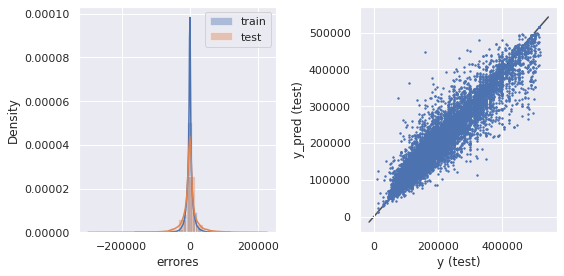

In [78]:
# Evaluamos los resultados obtenidos por el modelo
rmse_train, rmse_test, r2_train, r2_test = evaluar_modelo('Random Forest Regressor (parametros por defecto)', y_train, y_test, y_train_pred, y_test_pred)

In [79]:
# Almacenamos los resultados obtenidos por el modelo
resultados_PY_02_RFR_Model = {'Modelo': ['Random Forest Regressor'], 
                              'RMSE_Train': [rmse_train], 
                              'RMSE_Test': [rmse_test], 
                              'R2_Train': [r2_train],
                              'R2_Test': [r2_test]
                              }

In [80]:
# # Guardado del modelo ya entrenado
# path_RFR_Model = '/content/drive/MyDrive/Colab Notebooks/00_Acamica/RFR_Model.sav'
# pickle.dump(RFR_Model, open(path_RFR_Model, 'wb'))

#### ---> Cross Validation

Mediante la técnica de Cross Validation corroboramos que el valor obtenido para las métricas es el valor representativo indiferente del conjunto de train y test seleccionado.

In [81]:
# CV_RFR_Model_results = cross_validate(RFR_Model, X_test, y_test, cv=5, scoring=['r2', 'neg_root_mean_squared_error'], return_train_score=True,  n_jobs=-1)
# CV_RFR_Model_results

In [82]:
# CV_RFR_Model_R2 = CV_RFR_Model_results['test_r2']
# CV_RFR_Model_RMSE = CV_RFR_Model_results['test_neg_root_mean_squared_error']

In [83]:
# print('Modelo evaluado bajo Cross Validation:  Random Forest Regressor (parametros por defecto)')
# print("Raíz del error cuadrático medio : %0.2f (+/- %0.2f)" % (abs(CV_RFR_Model_RMSE.mean()), abs(CV_RFR_Model_RMSE.std()) * 2))
# print("R cuadrado : %0.2f (+/- %0.2f)" % (abs(CV_RFR_Model_R2.mean()), abs(CV_RFR_Model_R2.std()) * 2))

## **B. 02.** Modelos avanzados (hiperparámetros optimizados)

En la presente sección generaremos la optimización de hiperparámetros de los modelos XGBoost y Random Forest Regressor empleando técnicas de grilla, en específico Random Search y Grid Search. Los modelos serán evaluados a partir de las métricas ya definidas empleando a su vez validación cruzada. A partir de dicha evaluación se definirán los mejores modelos en relación con  los hiperparámetros optimizados.

### **B.02.01.** XGBoost (argumentos optimizados)

Con el fin de optimizar el modelo de XGBoost hemos decidido utilizar la técnica de Random Search. Esta técnica evalúa un conjunto especifico de modelos de manera aleatoria entre todas las posibles combinaciones dadas por el conjunto de valores que hayamos definido para cada hiperparámetro. En nuestro caso hemos definido este conjunto de modelos como 50.  Los hiperparámetros que hemos considerado más relevantes para el modelo de XGBoost son los siguientes: 
- **Nthread** [Valores posibles: 1, 2, 3, 4, 5]: Número de subprocesos paralelos utilizados para ejecutar XGBoost.
- **Objective** [Valor: 'reg:squarederror']: Especifica la tarea de aprendizaje y el objetivo de aprendizaje correspondiente. Nos enfocaremos en la evaluación del RMSE que indirectamente también tendrá que ver con la optimización del R2.
- **Learning_rate** [Valores posibles: .0.05 - 1]: Reducción del tamaño del paso utilizado en la actualización para evitar el sobreajuste.
- **Max_depth** [Valores posibles: rango 1-10]: nos permite evaluar si la profundidad de árboles con que se construye el modelo tiene una influencia en el resultado del mismo.
- **Min_child_weight** [Valores posibles: 3, 4, 5, 6, 7, 8]: evaluar la suma mínima de peso de instancia necesaria para una nueva división.
- **Subsample** [Valores posibles: rango 0.05 - 1]: Proporción de submuestras de las instancias de formación.
- **Colsample_bytree** [Valores posibles: rango 0.05 - 1]: es la proporción de submuestras de columnas al construir cada árbol. El submuestreo ocurre una vez por cada árbol construido.
- **N_estimators** [Valores posibles: 200, 300, 400, 500, 600]: nos permite evaluar si la cantidad de estimadores con que se construye el modelo tiene una influencia en el resultado del mismo.



In [84]:
# # Definimos el modelo base a partir del cual haremos la optimización
# XGB_model_base = xgb.XGBRegressor()

In [85]:
# # Definimos el conjunto de hiperparametros a partir del cual del cual harémos la optimización
# param_XGB_model_base = {'nthread':[1, 2, 3, 4, 5], 
#               'objective':['reg:squarederror'],
#               'learning_rate': np.arange(.05, 1, .05),
#               'max_depth': np.arange(1,10),
#               'min_child_weight': [3, 4, 5, 6, 7, 8],
#               'subsample': np.arange(.05, 1, .05),
#               'colsample_bytree': np.arange(.05, 1, .05),
#               'n_estimators': [200, 300, 400, 500, 600]}
# param_XGB_model_base

In [86]:
# # A partir del modelo base y del conjunto de parametros definimos a través de una busqueda aleatoria con 50 iteraciones, 
# # los parametros a ser tenidos en cuanta para cada uno de los modelos.
# XGB_model_RS = RandomizedSearchCV(XGB_model_base, param_XGB_model_base,n_iter=50, random_state=0, cv=5,
#                             scoring='r2', verbose=True, n_jobs=-1, refit=True)

In [87]:
# # Generamos el entrenamiento del conjunto de modelos definidos en la busqueda aleatoria
# XGB_model_RS.fit(X_train, y_train,
#         eval_set=[(X_train, y_train), (X_test, y_test)],
#         early_stopping_rounds=50,
#         verbose=True)

In [88]:
# Cargado del modelo guardado (una vez ya ha sido entrenado)
path_XGB_model_RS = '/content/drive/MyDrive/Colab Notebooks/00_Acamica/XGB_model_RS.sav'
XGB_model_RS = pickle.load(open(path_XGB_model_RS, 'rb'))

In [89]:
# Evaluamos cual fue el mejor resultado obtenido para la métrica definida
XGB_model_RS.best_score_

0.9000048957872375

In [90]:
# Obtenemos los hiperparametros del modelo que presentó el mejor resultado para la métrica
XGB_model_RS.best_estimator_

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7500000000000001, gamma=0,
             gpu_id=-1, importance_type='gain', interaction_constraints='',
             learning_rate=0.3, max_delta_step=0, max_depth=9,
             min_child_weight=6, missing=nan, monotone_constraints='()',
             n_estimators=200, n_jobs=5, nthread=5, num_parallel_tree=1,
             random_state=0, reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
             subsample=0.6500000000000001, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [91]:
# Consultamos la iteración para la cual el modelo presentó el mejor resultado para la métrica
best_score = np.argmax(XGB_model_RS.cv_results_['mean_test_score'])
best_score

46

In [92]:
# Imprimimos los resultados obtenidos para el mejor modelo así como los hiperparametros elegidos dela grilla 
print('mean_test_f1', XGB_model_RS.cv_results_['mean_test_score'][best_score])
print('params', XGB_model_RS.cv_results_['params'][best_score])

mean_test_f1 0.9000048957872375
params {'subsample': 0.6500000000000001, 'objective': 'reg:squarederror', 'nthread': 5, 'n_estimators': 200, 'min_child_weight': 6, 'max_depth': 9, 'learning_rate': 0.3, 'colsample_bytree': 0.7500000000000001}


In [93]:
# Generamos la predicción con el modelo que mejor métrica presento
y_train_pred = XGB_model_RS.predict(X_train)
y_test_pred= XGB_model_RS.predict(X_test)

El modelo a evaluar:  XGBoost optimizado
Raíz del error cuadrático medio en Train: 16293.760700252544
Raíz del error cuadrático medio en Test: 27599.2807844193
R cuadrado en Train: 0.9686553993120743
R cuadrado en Test: 0.911215587266194


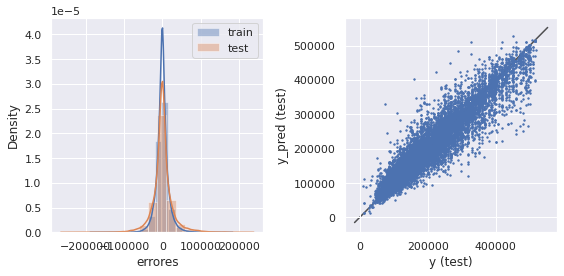

In [94]:
# Evaluamos los resultados obtenidos por el mejor modelo
rmse_train, rmse_test, r2_train, r2_test = evaluar_modelo('XGBoost optimizado', y_train, y_test, y_train_pred, y_test_pred)

In [95]:
# Almacenamos los resultados obtenidos por el modelo
resultados_PY_02_XGB_model_RS = {'Modelo': ['XGBoost optimizado'], 
                              'RMSE_Train': [rmse_train], 
                              'RMSE_Test': [rmse_test], 
                              'R2_Train': [r2_train],
                              'R2_Test': [r2_test]
                              }

In [96]:
# # Guardado del modelo ya entrenado
# path_XGB_model_RS = '/content/drive/MyDrive/Colab Notebooks/00_Acamica/XGB_model_RS.sav'
# pickle.dump(XGB_model_RS, open(path_XGB_model_RS, 'wb'))

### **B.02.02** Random Forest Regressor (argumentos optimizados)

Con el fin de optimizar el modelo de Random Forest Regressor hemos decidido utilizar la técnica de Grid Search. Dado que dicha técnica evalúa todas las posibles combinaciones dadas por el conjunto de valores que hayamos definido para cada hiperparámetro, definimos un conjunto reducido de hiperparámetros y de valores que son los que hemos considerado más relevantes para un RFR para hacer la ejecución más eficiente. Los hiperparametros elegidos son los siguientes:
- **Boostrap** [Valores posibles: False, True]: Nos permite elegir si tomamos la totalidad de las muestras para construir cada árbol, o si se utilizan muestras para cada uno de ellos.
- **Max_depth** [Valores posibles: 10, 100]: Nos permite evaluar si la profundidad del árbol nos permite mejorar la predicción.
- **Max_features** [Valores posibles: ‘auto’, 100]: nos permite evaluar si la cantidad de características a considerar al buscar la mejor división.
- **N_estimators** [Valores posibles: 200, 1000]: nos permite evaluar si la cantidad de árboles con que se construye el modelo tiene una influencia en el resultado del mismo.


In [97]:
# # Definimos el modelo base a partir del cual haremos la optimización
# RFR_model_base = RandomForestRegressor()

In [98]:
# # Definimos el conjunto de hiperparametros a partir del cual del cual harémos la optimización
# param_RFR_model_base = {'bootstrap': [True, False],
#             'max_depth': [10, 100],
#             'max_features': ['auto', 'sqrt'],
#             'n_estimators': [200, 1000]}
# param_RFR_model_base

In [99]:
# # A partir del modelo base y del conjunto de parametros definimos a través de una busqueda por grilla 
# # los parametros a ser tenidos en cuanta para cada uno de los modelos.
# RFR_model_RS = GridSearchCV(RFR_model_base, param_RFR_model_base, cv=5,
#                             scoring='r2', verbose=True, n_jobs=-1, refit=True)

In [100]:
# # Generamos el entrenamiento del conjunto de modelos definidos en la busqueda por grilla
# RFR_model_RS.fit(X_train, y_train)

In [101]:
# Cargado del modelo guardado (una vez ya ha sido entrenado)
path_RFR_model_RS = '/content/drive/MyDrive/Colab Notebooks/00_Acamica/RFR_model_RS.sav'
RFR_model_RS = pickle.load(open(path_RFR_model_RS, 'rb'))

In [102]:
# Evaluamos cual fue el mejor resultado obtenido para la métrica definida
RFR_model_RS.best_score_

0.9138724931367233

In [103]:
# Evaluamos cual fue el mejor resultado obtenido para la métrica definida
RFR_model_RS.best_score_

0.9138724931367233

In [104]:
# Obtenemos los hiperparametros del modelo que presentó el mejor resultado para la métrica
RFR_model_RS.best_estimator_

RandomForestRegressor(bootstrap=False, max_depth=100, max_features='sqrt',
                      n_estimators=1000)

In [105]:
# Consultamos la iteración para la cual el modelo presentó el mejor resultado para la métrica
best_score = np.argmax(RFR_model_RS.cv_results_['mean_test_score'])
best_score

15

In [106]:
# Imprimimos los resultados obtenidos para el mejor modelo así como los hiperparametros elegidos dela grilla 
print('mean_test_R2', RFR_model_RS.cv_results_['mean_test_score'][best_score])
print('params', RFR_model_RS.cv_results_['params'][best_score])

mean_test_R2 0.9138724931367233
params {'bootstrap': False, 'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 1000}


In [107]:
# Generamos la predicción con el modelo que mejor métrica presento
y_train_pred = RFR_model_RS.predict(X_train)
y_test_pred= RFR_model_RS.predict(X_test)

El modelo a evaluar:  Random Forest Regressor optimizado
Raíz del error cuadrático medio en Train: 5317.005242587459
Raíz del error cuadrático medio en Test: 25308.45771476467
R cuadrado en Train: 0.9966622465676773
R cuadrado en Test: 0.9253426522552916


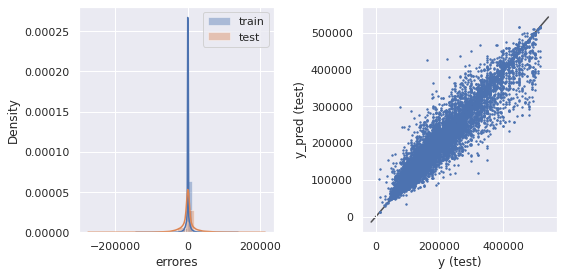

In [108]:
# Evaluamos los resultados obtenidos por el mejor modelo
rmse_train, rmse_test, r2_train, r2_test = evaluar_modelo('Random Forest Regressor optimizado', y_train, y_test, y_train_pred, y_test_pred)

In [109]:
# Almacenamos los resultados obtenidos por el modelo
resultados_PY_02_RFR_model_RS = {'Modelo': ['Random Forest Regressor optimizado'], 
                              'RMSE_Train': [rmse_train], 
                              'RMSE_Test': [rmse_test], 
                              'R2_Train': [r2_train],
                              'R2_Test': [r2_test]
                              }

In [110]:
# # Guardado del modelo ya entrenado
# path_RFR_model_RS = '/content/drive/MyDrive/Colab Notebooks/00_Acamica/RFR_model_RS.sav'
# pickle.dump(RFR_model_RS, open(path_RFR_model_RS, 'wb'))

In [111]:
print("--- %s seconds ---" % (time.time() - start_time))

--- 206.17869472503662 seconds ---


## **B. 03.** Evaluación de desempeño

En la presente sección recopilamos los resultados de las métricas RMSE y R2 para la totalidad de los modelos evaluados en el Proyecto_01 y en el proyecto actual. Como resultados relevantes en relación con el desempeño de los modelos destacamos los siguientes:

1. **Transformación de datos (implicaciones):** La transformación de datos tiene implicaciones importantes dentro de la mejora de las estimaciones para todos los modelos evaluados. Transformando únicamente el dataset de entrada, aun sin modificar ningún hiperparámetro, evidencia una mejora en las métricas para la totalidad de los modelos del primer proyecto (árboles de decisión, regresión lineal y Vecinos más cercanos). La mejora más relevante en la métrica del R2 se evidencia en el modelo del regresor lineal, seguido por los modelos de Vecinos más Cercanos y Árboles de decisión. En la sección A.06. Comparación resultados de los modelos (Proyecto 01 Vs Proyecto actual) ya fueran definidas de manera detallada las implicaciones de cada proceso de transformación el más mejoras encontradas en los modelos.
2. **Modelos avanzados sin optimización (modelos de ensamble):** Los resultados para los modelos de Random Forest Regressor y XGBoost fueron superiores a los evidenciados para cualquiera de los modelos vistos en anteriores proyectos. Tanto la métrica de RMSE como la de R2 fueron superiores tanto para los datos de entrenamiento como para los datos de testeo, conformando así que las técnicas de ensamble proveen ventajas significativas frente a los modelos que no presentan combinaciones. Aún sin optimizaciones para sus hiperparametros el modelo de Random Forest Regressor presenta un metrica de R2 para el conjunto de test superior a 0.9 y el modelo de XGboost superior al 0.85 en el mismo conjunto. 
3. **Modelos avanzados con  optimización (modelos de ensamble):** tanto el modelo de XGBoost como el modelos de Random Forest Regressor presentaron mejoras en sus métricas empleando los procesos de optimización a través de las técnicas de Random y Grid Search. Sin embargo estas implementaciones suponen tiempos de cálculo y recursos en memoria y procesamiento mucho mayores que es importante tener en cuenta al implementarlos. También es de notar que los incrementos en los valores de las métricas pueden no ser muy notables, por lo cual la relación costo beneficio del proceso de optimización debe evaluarse con detalle, e implementarse exclusivamente en el caso que tal incremento, por leve que sea, involucre una ventaja necesaria en la implementación.
4. **Modelo elegido:** Aunque el modelo de Random Forest Regressor Optimizado fue el que presentó los mejores valores para las métricas evaluadas, el tiempo de entrenamiento y el tamaño en memoria ocupado para su optimización hacen que en una relación costo beneficio comparado con el mismo modelo sin optimización, no sea favorable. Si se tiene en cuenta el tamaño del modelo que es una característica importante al momento de poner los modelos en producción el modelo que elegiría sería el de XGBoost optimizado pues presenta la 3 posición en relación con las mejores métricas (un R2 superior a 0.9) pero en tamaño en memoria es 100 veces más ligero que el RFR.


In [112]:
# Creamos los dataframes con los resultados de los modelos avanzados sin optimización
df_resultados_PY_02_XGB_model = pd.DataFrame.from_dict(resultados_PY_02_XGB_model)
df_resultados_PY_02_XGB_model['Proyecto']='PY_02'
df_resultados_PY_02_XGB_model = df_resultados_PY_02_XGB_model[['Modelo', 'Proyecto', 'RMSE_Train', 'RMSE_Test', 'R2_Train', 'R2_Test']]
df_resultados_PY_02_XGB_model[['R2_Train', 'R2_Test']] = df_resultados_PY_02_XGB_model[['R2_Train', 'R2_Test']]

df_resultados_PY_02_RFR_Model = pd.DataFrame.from_dict(resultados_PY_02_RFR_Model)
df_resultados_PY_02_RFR_Model['Proyecto']='PY_02'
df_resultados_PY_02_RFR_Model = df_resultados_PY_02_RFR_Model[['Modelo', 'Proyecto', 'RMSE_Train', 'RMSE_Test', 'R2_Train', 'R2_Test']]
df_resultados_PY_02_RFR_Model[['R2_Train', 'R2_Test']] = df_resultados_PY_02_RFR_Model[['R2_Train', 'R2_Test']]


In [113]:
# Creamos los dataframes con los resultados de los modelos avanzados con optimización
df_resultados_PY_02_XGB_model_RS = pd.DataFrame.from_dict(resultados_PY_02_XGB_model_RS)
df_resultados_PY_02_XGB_model_RS['Proyecto']='PY_02'
df_resultados_PY_02_XGB_model_RS = df_resultados_PY_02_XGB_model_RS[['Modelo', 'Proyecto', 'RMSE_Train', 'RMSE_Test', 'R2_Train', 'R2_Test']]
df_resultados_PY_02_XGB_model_RS[['R2_Train', 'R2_Test']] = df_resultados_PY_02_XGB_model_RS[['R2_Train', 'R2_Test']]

df_resultados_PY_02_RFR_model_RS = pd.DataFrame.from_dict(resultados_PY_02_RFR_model_RS)
df_resultados_PY_02_RFR_model_RS['Proyecto']='PY_02'
df_resultados_PY_02_RFR_model_RS = df_resultados_PY_02_RFR_model_RS[['Modelo', 'Proyecto', 'RMSE_Train', 'RMSE_Test', 'R2_Train', 'R2_Test']]
df_resultados_PY_02_RFR_model_RS[['R2_Train', 'R2_Test']] = df_resultados_PY_02_RFR_model_RS[['R2_Train', 'R2_Test']]

In [114]:
# Concatenamos todos los resultados de los modelos implementados
df_resultados_compilados_totales = pd.concat([df_resultados_PY_01,
                                      df_resultados_PY_02,
                                      df_resultados_PY_02_XGB_model,
                                      df_resultados_PY_02_RFR_Model,
                                      df_resultados_PY_02_XGB_model_RS,
                                      df_resultados_PY_02_RFR_model_RS])
df_resultados_compilados_totales = df_resultados_compilados_totales.sort_values(by='R2_Test', ascending=False).reset_index(drop=True)
df_resultados_compilados_totales

,Modelo,Proyecto,RMSE_Train,RMSE_Test,R2_Train,R2_Test
0,Random Forest Regressor optimizado,PY_02,5317.005243,25308.457715,0.996662,0.925343
1,Random Forest Regressor,PY_02,10975.059244,26126.047736,0.985779,0.920441
2,XGBoost optimizado,PY_02,16293.760700,27599.280784,0.968655,0.911216
3,XGBoost,PY_02,28005.652518,32175.555798,0.907400,0.879332
4,Vecinos más cercanos,PY_02,27331.957836,34287.791937,0.911801,0.862969
5,Regresión lineal,PY_02,44143.814089,44214.729420,0.769930,0.772136
6,Vecinos más cercanos,PY_01,121300.240494,155040.133290,0.833758,0.736954
7,Árbol de Decisión,PY_02,54385.934555,54646.030600,0.650785,0.651937
8,Árbol de Decisión,PY_01,191783.485244,194688.150912,0.584433,0.585216
9,Regresión lineal,PY_01,199173.832535,202449.365404,0.551789,0.551486


In [122]:
# Calculamos e imprimimos el tamaño de los modelos avanzados implementados
size_XGB_model = sys.getsizeof(pickle.dumps(XGB_model))/1E6
size_XGB_model_RS = sys.getsizeof(pickle.dumps(XGB_model_RS))/1E6
size_RFR_model = sys.getsizeof(pickle.dumps(RFR_Model))/1E6
size_RFR_model_RS = sys.getsizeof(pickle.dumps(RFR_model_RS))/1E6

print('Tamaño de los modelos en MB al almacenarse:')
print('XGBoost:', size_XGB_model)
print('XGBoost Optimizado:', size_XGB_model_RS)
print('Random Forest Regressor:', size_RFR_model)
print('Random Forest Regressor Optimizado:', size_RFR_model_RS)

Tamaño de los modelos en MB al almacenarse:
XGBoost: 0.591817
XGBoost Optimizado: 2.950495
Random Forest Regressor: 224.845074
Random Forest Regressor Optimizado: 3368.260109


# Parte C. Interpretación de los modelos.

## **C. 01.** Variables importantes para los modelos

## **C. 02.** Distribución de errores

## **C. 03.** Discusión y conclusiones

<Figure size 1080x720 with 0 Axes>

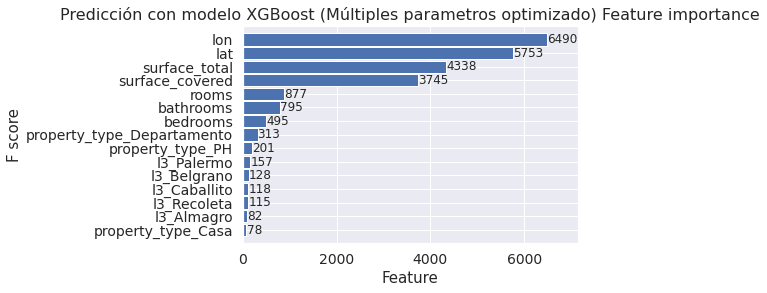

In [119]:
plt.figure(figsize = (15,10))
plot_importance(XGB_model_RS.best_estimator_, height=0.9,max_num_features=15)
plt.title('Predicción con modelo XGBoost (Múltiples parametros optimizado) Feature importance',fontsize=16)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('F score', fontsize=15)
plt.tick_params(labelsize=14)
plt.show()

# Parte C. Interpretación de los modelos

In [ ]:
plt.figure(figsize = (15,10))
plot_importance(XGB_model_RS.best_estimator_, height=0.9,max_num_features=15)
plt.title('Predicción con modelo XGBoost (Múltiples parametros optimizado) Feature importance',fontsize=16)
plt.xlabel('Feature', fontsize=15)
plt.ylabel('F score', fontsize=15)
plt.tick_params(labelsize=14)
plt.show()